In [ ]:
# In this file, trying lightGBM with cross validation
# try the package in scikit-learn too
# single thread

# lgb document: http://lightgbm.readthedocs.io/en/latest/python/lightgbm.html#lightgbm-package
# xgb document: http://xgboost.readthedocs.io/en/latest/python/python_api.html

# LightGBM scikit-learn API: http://lightgbm.readthedocs.io/en/latest/python/lightgbm.html#scikit-learn-api
# XGBoost scikit-learn API: http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
# both scikit-learn lightGBM, Xgboost provide regressor and classifier

In [17]:
import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame 
import lightgbm as lgb 
import xgboost as xgb 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split 

In [8]:
data=pd.read_csv('adult.csv',header=None) 
# assign column names to the data
data.columns=['age','workclass','fnlwgt','education','education-num','marital_Status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','Income'] 
data.head()

,age,workclass,fnlwgt,education,education-num,marital_Status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
# data preprocessing

## encode label
l=LabelEncoder() 
l.fit(data.Income) 
l.classes_ 
data.Income=Series(l.transform(data.Income))
data.Income.value_counts()

0    24720
1     7841
Name: Income, dtype: int64

In [10]:
## convert categorical data into one-hot, and drop original categorical data
one_hot_workclass=pd.get_dummies(data.workclass) 
one_hot_education=pd.get_dummies(data.education) 
one_hot_marital_Status=pd.get_dummies(data.marital_Status) 
one_hot_occupation=pd.get_dummies(data.occupation)
one_hot_relationship=pd.get_dummies(data.relationship) 
one_hot_race=pd.get_dummies(data.race) 
one_hot_sex=pd.get_dummies(data.sex) 
one_hot_native_country=pd.get_dummies(data.native_country) 

data.drop(['workclass','education','marital_Status','occupation','relationship','race','sex','native_country'],axis=1,inplace=True) 

In [ ]:
data=pd.concat([data,one_hot_workclass,one_hot_education,one_hot_marital_Status,one_hot_occupation,one_hot_relationship,one_hot_race,one_hot_sex,one_hot_native_country],axis=1) 
## remove dulpicate columns 
i = np.unique(data.columns, return_index=True) 
data=data.iloc[:, i[1]]  # use the index of unique columns
data.head()

In [12]:
features = data.drop('Income',axis=1) 
label = data.Income

In [13]:
label.mode()[0]
label.fillna(label.mode()[0],inplace=True)  # impute missing data with mode

In [14]:
label.value_counts()

0    24720
1     7841
Name: Income, dtype: int64

In [18]:
features_train,features_test,label_train,label_test=train_test_split(features,label,test_size=.3)

In [95]:
# method 1 - xgboost, with cross validation

dtrain=xgb.DMatrix(features_train,label=label_train)
dtest=xgb.DMatrix(features_test)
## booster params
booster_params = {'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}

In [49]:
num_boost_round = 50
nfold = 5
metrics = ('auc', 'logloss')
seed = 410

xgb_cv = xgb.cv(booster_params, dtrain, num_boost_round, nfold, metrics, seed)
print(xgb_cv.shape)

(50, 4)


In [48]:
xgb_cv   # it returns the optimum number of trees required (n_estimators)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.850824,0.003935,0.859200,0.001329
1,0.852598,0.003079,0.861530,0.001734
2,0.853106,0.003554,0.862625,0.001434
3,0.854285,0.004212,0.863689,0.001647
4,0.855042,0.004495,0.864591,0.000981
5,0.855559,0.004038,0.865549,0.000874
6,0.856063,0.003676,0.866360,0.001218
7,0.856301,0.003618,0.866771,0.001364
8,0.856692,0.003609,0.867315,0.001473
9,0.857321,0.003379,0.867708,0.001699


In [85]:
from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV 
from xgboost import plot_importance
%matplotlib inline

In [92]:
# CV method 1 - xgboost cv() method

def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = dtrain
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=('auc'), early_stopping_rounds=early_stopping_rounds, seed = 410)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg_fit = alg.fit(features_train, label_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features_train)
    dtrain_predprob = alg.predict_proba(features_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(label_train, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(label_train, dtrain_predprob))
                    
    plot_importance(alg_fit, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=7, grid=True,)
    
    return alg_fit


Model Report
Accuracy : 0.8522
AUC Score (Train): 0.894681
0:00:20.832283


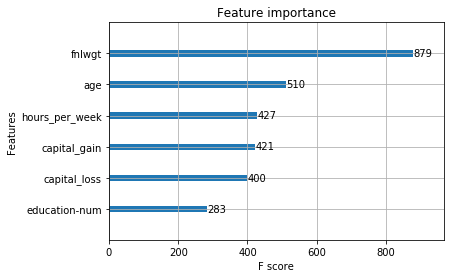

In [93]:
start=datetime.now()

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,  # default value here, will be changed by cvresult
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=410)
xgb_model = modelfit(xgb1, dtrain, features_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)  # 0:00:20.234687

In [99]:
ypred = xgb_model.predict(features_test) 
print(ypred)

[0 0 0 ..., 0 1 0]


In [102]:
accuracy_xgb = accuracy_score(label_test,ypred) 
print("sklearn accuracy", accuracy_xgb)

cm = confusion_matrix(label_test, ypred)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_xgb = (TP + TN)/(TP+FP+FN+TN)   # accuracy: 0.87030402293
auc_score_xgb = roc_auc_score(label_test, ypred)   # AUC: 0.777341026858
precision_xgb = TP/(TP+FP)   # precision: 0.952047413793
specificity_xgb = TN/(TN+FP)  # specificity: 0.797612279704
recall_xgb = TP/(TP+FN)   # recall: 0.885017421603
print("accuracy: ", accuracy_xgb)
print("AUC: ", auc_score_xgb)
print("Precision: ", precision_xgb)
print("Specificity: ", specificity_xgb)
print("Recall: ", recall_xgb)

sklearn accuracy 0.847476712048
accuracy:  0.847476712048
AUC:  0.722712689445
Precision:  0.957236402512
Specificity:  0.777158774373
Recall:  0.859594383775


In [109]:
# CV method 2 - GridSearchCV() method
## GridSearchCV params: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

param_set = {
 'max_depth':[3,5,7,9],
 'min_child_weight':[1,3,5]  # smaller min_child_weight can handle smaller class in inbalanced dataset
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

In [110]:
xgb_model2 = gsearch.fit(features_train, label_train)
xgb_model2.grid_scores_, xgb_model2.best_params_, xgb_model2.best_score_

([mean: 0.86903, std: 0.00681, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.86902, std: 0.00695, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.86865, std: 0.00690, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.87415, std: 0.00686, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.87371, std: 0.00721, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.87281, std: 0.00723, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.87421, std: 0.00724, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.87388, std: 0.00693, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.87271, std: 0.00696, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.87298, std: 0.00649, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.87169, std: 0.00657, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.87116, std: 0.00658, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 1

In [111]:
# modify values with optimum values and tune other params

param_set = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model2 = gsearch.fit(features_train, label_train)
xgb_model2.grid_scores_, xgb_model2.best_params_, xgb_model2.best_score_

([mean: 0.87421, std: 0.00724, params: {'gamma': 0.0},
  mean: 0.87483, std: 0.00685, params: {'gamma': 0.1},
  mean: 0.87472, std: 0.00677, params: {'gamma': 0.2},
  mean: 0.87498, std: 0.00677, params: {'gamma': 0.3},
  mean: 0.87459, std: 0.00688, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.8749824643981604)

In [112]:
# modify values with optimum values and tune other params

param_set = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model2 = gsearch.fit(features_train, label_train)
xgb_model2.grid_scores_, xgb_model2.best_params_, xgb_model2.best_score_

([mean: 0.87401, std: 0.00714, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.87436, std: 0.00757, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.87529, std: 0.00698, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.87563, std: 0.00686, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.87269, std: 0.00743, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.87321, std: 0.00703, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.87498, std: 0.00677, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.87539, std: 0.00634, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.87269, std: 0.00743, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.87321, std: 0.00703, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.87498, std: 0.00677, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.87539, std: 0.00634, params: {'colsample_bytree': 0.8, 'subsample'

In [113]:
# subsample and colsample_bytree are choosing edge values, check in more detail

param_set = {
 'subsample':[0.8, 0.9, 1.0],
 'colsample_bytree':[i/10.0 for i in range(1,7)]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model2 = gsearch.fit(features_train, label_train)
xgb_model2.grid_scores_, xgb_model2.best_params_, xgb_model2.best_score_

([mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.1, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.1, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.1, 'subsample': 1.0},
  mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.2, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.2, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.2, 'subsample': 1.0},
  mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.3, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.3, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.3, 'subsample': 1.0},
  mean: 0.87595, std: 0.00658, params: {'colsample_bytree': 0.4, 'subsample': 0.8},
  mean: 0.87595, std: 0.00696, params: {'colsample_bytree': 0.4, 'subsample': 0.9},
  mean: 0.87584, std: 0.00704, params: {'colsample_bytree': 0.4, 'subsample'

In [119]:
# subsample and colsample_bytree are choosing edge

param_set = {
 'subsample':[0.8, 0.9, 1.0],
 'colsample_bytree':[i/100.0 for i in range(1,10,2)]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model2 = gsearch.fit(features_train, label_train)
xgb_model2.grid_scores_, xgb_model2.best_params_, xgb_model2.best_score_   # got the same accuracy in fact

([mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.01, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.01, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.01, 'subsample': 1.0},
  mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.03, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.03, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.03, 'subsample': 1.0},
  mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.05, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.05, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.05, 'subsample': 1.0},
  mean: 0.87571, std: 0.00650, params: {'colsample_bytree': 0.07, 'subsample': 0.8},
  mean: 0.87618, std: 0.00708, params: {'colsample_bytree': 0.07, 'subsample': 0.9},
  mean: 0.87641, std: 0.00686, params: {'colsample_bytree': 0.07,


Model Report
Accuracy : 0.8452
AUC Score (Train): 0.888306
0:00:07.113186
[0 0 0 ..., 0 1 0]


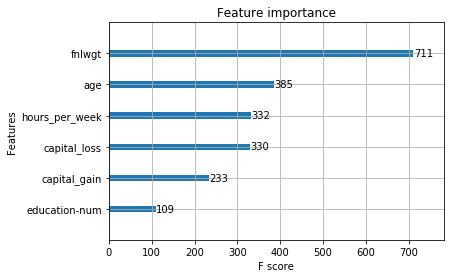

In [120]:
start=datetime.now()

xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=7,
 min_child_weight=1,
 gamma=0.3,
 subsample=1.0,
 colsample_bytree=0.1,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 seed=410)
xgb_model2 = modelfit(xgb2, dtrain, features_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)      # 0:00:07.11318

ypred = xgb_model2.predict(features_test) 
print(ypred)

In [121]:
ypred2=xgb_model2.predict(features_test)
ypred2[0:5]

array([0, 0, 0, 0, 1])

In [122]:
cm = confusion_matrix(label_test, ypred2)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_xgb = (TP + TN)/(TP+FP+FN+TN)   # accuracy: 0.87030402293
auc_score_xgb = roc_auc_score(label_test, ypred)   # AUC: 0.777341026858
precision_xgb = TP/(TP+FP)   # precision: 0.952047413793
specificity_xgb = TN/(TN+FP)  # specificity: 0.797612279704
recall_xgb = TP/(TP+FN)   # recall: 0.885017421603
print("accuracy: ", accuracy_xgb)
print("AUC: ", auc_score_xgb)
print("Precision: ", precision_xgb)
print("Specificity: ", specificity_xgb)
print("Recall: ", recall_xgb)

accuracy:  0.848397993653
AUC:  0.709338834984
Precision:  0.970733662969
Specificity:  0.823813354787
Recall:  0.851982172179


In [132]:
# modify values with optimum values and tune other params

param_set = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model3 = gsearch.fit(features_train, label_train)
xgb_model3.grid_scores_, xgb_model3.best_params_, xgb_model3.best_score_

([mean: 0.87641, std: 0.00686, params: {'reg_alpha': 1e-05},
  mean: 0.87637, std: 0.00690, params: {'reg_alpha': 0.01},
  mean: 0.87621, std: 0.00699, params: {'reg_alpha': 0.1},
  mean: 0.87540, std: 0.00711, params: {'reg_alpha': 1},
  mean: 0.85617, std: 0.00683, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.8764095331109016)

In [133]:
# further tune reg_alpha value

param_set = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model3 = gsearch.fit(features_train, label_train)
xgb_model3.grid_scores_, xgb_model3.best_params_, xgb_model3.best_score_

([mean: 0.87641, std: 0.00686, params: {'reg_alpha': 0},
  mean: 0.87640, std: 0.00687, params: {'reg_alpha': 0.001},
  mean: 0.87640, std: 0.00688, params: {'reg_alpha': 0.005},
  mean: 0.87637, std: 0.00690, params: {'reg_alpha': 0.01},
  mean: 0.87634, std: 0.00704, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0},
 0.8764095331109016)


Model Report
Accuracy : 0.8452
AUC Score (Train): 0.888306
0:00:07.100202
[0 0 0 ..., 0 1 0]


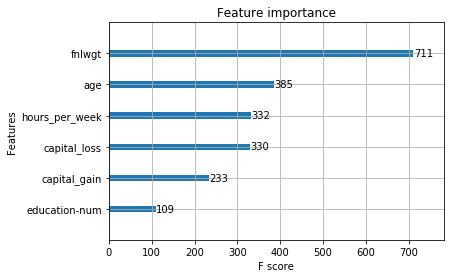

In [130]:
start=datetime.now()

xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=7,
 min_child_weight=1,
 gamma=0.3,
 subsample=1.0,
 colsample_bytree=0.1,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 reg_alpha = 0,
 seed=410)
xgb_model3 = modelfit(xgb3, dtrain, features_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)      # 0:00:07.100202

ypred = xgb_model3.predict(features_test) 
print(ypred)

In [131]:
ypred3=xgb_model3.predict(features_test)

cm = confusion_matrix(label_test, ypred3)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_xgb = (TP + TN)/(TP+FP+FN+TN)   # accuracy: 0.87030402293
auc_score_xgb = roc_auc_score(label_test, ypred)   # AUC: 0.777341026858
precision_xgb = TP/(TP+FP)   # precision: 0.952047413793
specificity_xgb = TN/(TN+FP)  # specificity: 0.797612279704
recall_xgb = TP/(TP+FN)   # recall: 0.885017421603
print("accuracy: ", accuracy_xgb)
print("AUC: ", auc_score_xgb)
print("Precision: ", precision_xgb)
print("Specificity: ", specificity_xgb)
print("Recall: ", recall_xgb)

accuracy:  0.848397993653
AUC:  0.709338834984
Precision:  0.970733662969
Specificity:  0.823813354787
Recall:  0.851982172179


In [134]:
# tune scale_pos_weight
## A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.

# tune learning rate

param_set = {
 'scale_pos_weight':[i/10.0 for i in range(11)]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model4 = gsearch.fit(features_train, label_train)
xgb_model4.grid_scores_, xgb_model4.best_params_, xgb_model4.best_score_

([mean: 0.50000, std: 0.00000, params: {'scale_pos_weight': 0.0},
  mean: 0.87003, std: 0.00723, params: {'scale_pos_weight': 0.1},
  mean: 0.87276, std: 0.00751, params: {'scale_pos_weight': 0.2},
  mean: 0.87382, std: 0.00722, params: {'scale_pos_weight': 0.3},
  mean: 0.87469, std: 0.00704, params: {'scale_pos_weight': 0.4},
  mean: 0.87489, std: 0.00709, params: {'scale_pos_weight': 0.5},
  mean: 0.87513, std: 0.00694, params: {'scale_pos_weight': 0.6},
  mean: 0.87550, std: 0.00716, params: {'scale_pos_weight': 0.7},
  mean: 0.87567, std: 0.00707, params: {'scale_pos_weight': 0.8},
  mean: 0.87593, std: 0.00715, params: {'scale_pos_weight': 0.9},
  mean: 0.87625, std: 0.00704, params: {'scale_pos_weight': 1.0}],
 {'scale_pos_weight': 1.0},
 0.8762515651925522)

In [135]:
# tune learning rate

param_set = {
 'learning_rate':[0.01, 0.05, 0.1]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model4 = gsearch.fit(features_train, label_train)
xgb_model4.grid_scores_, xgb_model4.best_params_, xgb_model4.best_score_

([mean: 0.86927, std: 0.00658, params: {'learning_rate': 0.01},
  mean: 0.87395, std: 0.00670, params: {'learning_rate': 0.05},
  mean: 0.87625, std: 0.00704, params: {'learning_rate': 0.1}],
 {'learning_rate': 0.1},
 0.8762515651925522)

In [136]:
# tune learning rate

param_set = {
 'learning_rate':[i/10.0 for i in range(1,10)]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model4 = gsearch.fit(features_train, label_train)
xgb_model4.grid_scores_, xgb_model4.best_params_, xgb_model4.best_score_

([mean: 0.87625, std: 0.00704, params: {'learning_rate': 0.1},
  mean: 0.87670, std: 0.00762, params: {'learning_rate': 0.2},
  mean: 0.87644, std: 0.00762, params: {'learning_rate': 0.3},
  mean: 0.87536, std: 0.00778, params: {'learning_rate': 0.4},
  mean: 0.87513, std: 0.00757, params: {'learning_rate': 0.5},
  mean: 0.87383, std: 0.00772, params: {'learning_rate': 0.6},
  mean: 0.87317, std: 0.00747, params: {'learning_rate': 0.7},
  mean: 0.87159, std: 0.00714, params: {'learning_rate': 0.8},
  mean: 0.87002, std: 0.00823, params: {'learning_rate': 0.9}],
 {'learning_rate': 0.2},
 0.8766982733341692)

In [137]:
# tune n_estimators

param_set = {
 'n_estimators':[50, 100, 500, 1000]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.2, n_estimators=100, max_depth=7,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.1, nthread=7,
 objective= 'binary:logistic', scale_pos_weight=1, seed=410), 
 param_grid = param_set, scoring='roc_auc',n_jobs=7,iid=False, cv=10)

xgb_model4 = gsearch.fit(features_train, label_train)
xgb_model4.grid_scores_, xgb_model4.best_params_, xgb_model4.best_score_

([mean: 0.87494, std: 0.00658, params: {'n_estimators': 50},
  mean: 0.87670, std: 0.00762, params: {'n_estimators': 100},
  mean: 0.87334, std: 0.00810, params: {'n_estimators': 500},
  mean: 0.87127, std: 0.00784, params: {'n_estimators': 1000}],
 {'n_estimators': 100},
 0.8766982733341692)


Model Report
Accuracy : 0.8499
AUC Score (Train): 0.893772
0:00:07.033940
[0 0 0 ..., 0 1 0]


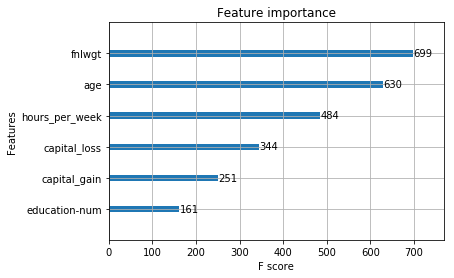

In [138]:
start=datetime.now()

xgb4 = XGBClassifier(
 learning_rate =0.2,
 n_estimators=100,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=1.0,
 colsample_bytree=0.1,
 objective= 'binary:logistic',
 nthread=7,
 scale_pos_weight=1,
 reg_alpha = 0,
 seed=410)
xgb_model4 = modelfit(xgb4, dtrain, features_train)

stop=datetime.now()
execution_time_lgbm = stop-start
print(execution_time_lgbm)      # 0:00:07.033940

ypred = xgb_model4.predict(features_test) 
print(ypred)

In [139]:
ypred4=xgb_model4.predict(features_test)

cm = confusion_matrix(label_test, ypred4)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy_xgb = (TP + TN)/(TP+FP+FN+TN)  
auc_score_xgb = roc_auc_score(label_test, ypred) 
precision_xgb = TP/(TP+FP)   
specificity_xgb = TN/(TN+FP)  
recall_xgb = TP/(TP+FN)  
print("accuracy: ", accuracy_xgb)
print("AUC: ", auc_score_xgb)
print("Precision: ", precision_xgb)
print("Specificity: ", specificity_xgb)
print("Recall: ", recall_xgb)

# both precision and specificity dropped, while accuracy, AUC, recall increased

accuracy:  0.848807452145
AUC:  0.721758470556
Precision:  0.960577308566
Specificity:  0.789135096497
Recall:  0.858781362007


In [ ]:
# Wait for lightGBM 2 corss methods here....